In [1]:
import pandapower as pp
from pandapower import runpp
from pandapower.plotting import simple_plotly, pf_res_plotly
import pandapower.networks as networks
from citylearn import CityLearn
from gridlearn import GridLearn
from agent import Do_Nothing_Agent, Randomized_Agent, RBC_Agent
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import random

In [2]:
np.random.seed(0)
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_ids = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9","Building_10"]
# building_ids = ["Building_1","Building_4","Building_5","Building_6"] # only building types with pv
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption', 'system_losses']
my_grid = GridLearn(data_path, building_attributes, weather_file, solar_profile, building_ids, 6, buildings_states_actions = building_state_actions, cost_function = objective_function, verbose=1, n_buildings_per_bus=1)

/Users/aislingpigott/Documents/CityLearn/citylearn.py:641: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.state = np.array(self.state)


In [3]:
# Simulation without energy storage
state = my_grid.reset()
done = False
# while not done:
# agent = Do_Nothing_Agent(my_grid)
# agent = Randomized_Agent(my_grid)
agent = RBC_Agent(my_grid)
for ts in range(6):
    action = agent.select_action(state)
    state, rewards, done, _ = my_grid.step(action)
    

/Users/aislingpigott/Documents/CityLearn/citylearn.py:641: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.state = np.array(self.state)


1.0


/Users/aislingpigott/Documents/CityLearn/citylearn.py:542: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.state.append(np.array(s))


1
1
1
1
2


In [ ]:
pf_res_plotly(my_grid.net)
print()

In [ ]:
{i: [0 for _ in range(sum(my_grid.buildings_states_actions[i]['actions'].values()))] for i in list(my_grid.buildings.keys())}

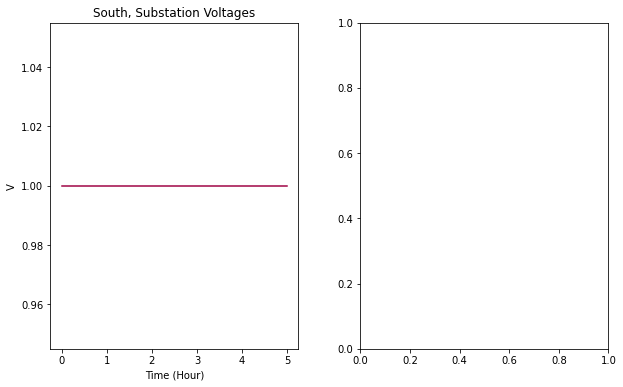

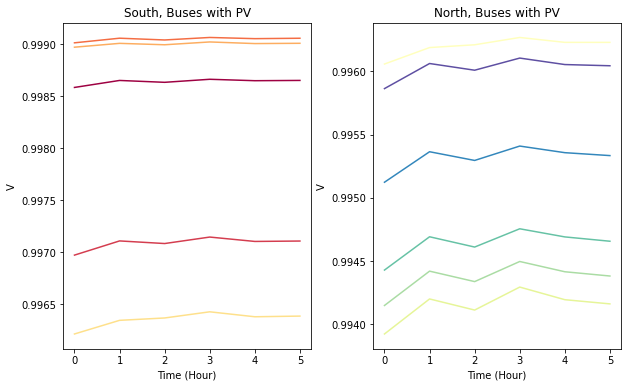

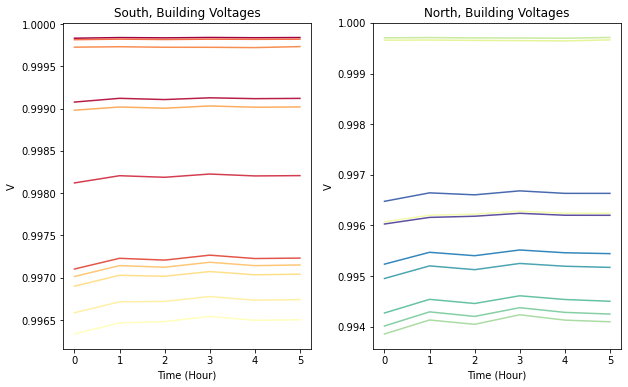

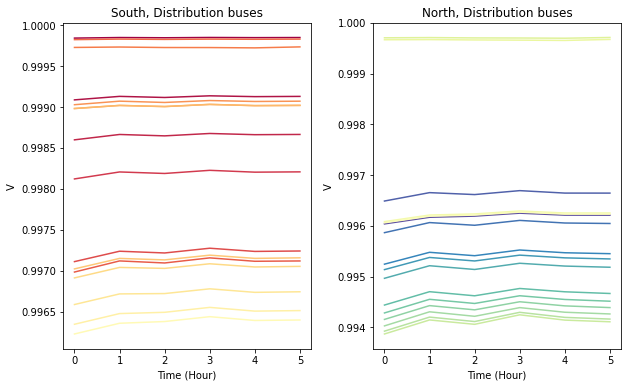

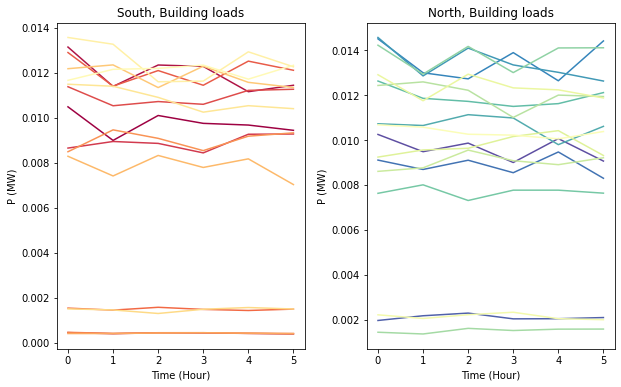

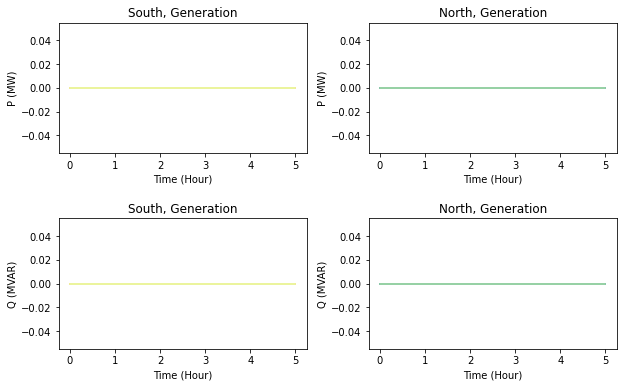

In [4]:
my_grid.plot_all()

In [ ]:
my_grid.cost()

In [ ]:
# Run this again after editing submodules so Colab uses the updated versions
from citylearn import CityLearn
from gridlearn import GridLearn
import matplotlib.pyplot as plt
from pathlib import Path
from agent import RL_Agents_Coord, Cluster_Agents
import numpy as np                                                                                                                                                                                      
import csv
import time
import re
import pandas as pd
import torch
from joblib import dump, load

# Load environment
climate_zone = 1
data_path = Path("data/Climate_Zone_"+str(climate_zone))
building_attributes = data_path / 'building_attributes.json'
weather_file = data_path / 'weather_data.csv'
solar_profile = data_path / 'solar_generation_1kW.csv'
building_state_actions = 'buildings_state_action_space.json'
building_id = ["Building_1","Building_2","Building_3","Building_4","Building_5","Building_6","Building_7","Building_8","Building_9"]
objective_function = ['ramping','1-load_factor','average_daily_peak','peak_demand','net_electricity_consumption','quadratic','system_losses']

print("Initializing the grid...")
# Contain the lower and upper bounds of the states and actions, to be provided to the agent to normalize the variables between 0 and 1.
# Can be obtained using observations_spaces[i].low or .high
env = GridLearn(data_path, building_attributes, weather_file, solar_profile, building_id, 6, buildings_states_actions = building_state_actions, simulation_period = (0,4), cost_function = objective_function, verbose=1, n_buildings_per_bus=1)

# Hyperparameters
bs = 256
tau = 0.005
gamma = 0.99
lr = 0.0003
hid = [256,256]

n_episodes = 4

print("Initializing the agents...")
# Instantiating the control agent(s)
# agents = RL_Agents_Coord(env, list(env.buildings.keys()), discount = gamma, batch_size = bs, replay_buffer_capacity = 1e5, regression_buffer_capacity = 12*8760, tau=tau, lr=lr, hidden_dim=hid, start_training=8760*3, exploration_period = 8760*3+1,  start_regression=8760, information_sharing = True, pca_compression = .95, action_scaling_coef=0.5, reward_scaling = 5., update_per_step = 1, iterations_as = 2)
agents = Cluster_Agents(env, 1, discount = gamma, batch_size = bs, replay_buffer_capacity = 1e5, regression_buffer_capacity = 12*8760, tau=tau, lr=lr, hidden_dim=hid, start_training=8760*3, exploration_period = 8760*3+1,  start_regression=8760, information_sharing = True, pca_compression = .95, action_scaling_coef=0.5, reward_scaling = 5., update_per_step = 1, iterations_as = 2)

print("Starting the experiment...")
# The number of episodes can be replaces by a stopping criterion (i.e. convergence of the average reward)
start = time.time()
for e in range(n_episodes): 
    is_evaluating = (e > 7) # Evaluate deterministic policy after 7 epochs
    rewards = []
    s = env.reset()
    done = False

    j = 0
    print("Intializing the agent actions...")
#     action, coordination_vars = agents.select_action(state, deterministic=is_evaluating)    
    agents.initialize_actions(s, deterministic=is_evaluating)
    print("Stepping through environment...")
    while not done:
        x = agents.step(s, is_evaluating)
        s = x[0]
#         next_state, reward, done, _ = env.step(action)
#         action_next, coordination_vars_next = agents.select_action(next_state, deterministic=is_evaluating)
#         agents.add_to_buffer(state, action.values(), reward, next_state, done, coordination_vars, coordination_vars_next)

#         state = next_state
#         coordination_vars = coordination_vars_next
#         action = action_next

    print('Loss -',env.cost(), 'Simulation time (min) -',(time.time()-start)/60.0)

In [ ]:
for k,v in agents.encoder.items():
    print(len(v))

In [ ]:
all_actions = []
all_selected = []
for key, value in action.items():
    all_actions += [sum(env.buildings_states_actions[key]['actions'].values())]
    all_selected += [len(value)]

In [ ]:
all_actions.count(1)

In [ ]:
all_selected.count(1)

In [ ]:
env.net.load.name.iloc[2]

In [ ]:
print(x)